In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

In [14]:
dftrain_x = pd.read_csv('X_train.csv', index_col='id')
dftrain_y = pd.read_csv('y_train.csv', index_col='id')
dftest_x = pd.read_csv('X_test.csv', index_col='id')

In [15]:
dftrain_x.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
id,,,,,,,,,,,,,,,,,,,,,
0.0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1.0,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2.0,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3.0,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4.0,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


# Imputation - Regression

In [16]:
#imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

In [17]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression
LR = LinearRegression() 

In [18]:
#feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
select = SelectKBest(score_func=f_regression, k=200)

In [19]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=0.001, kernel=RBF())

In [20]:
# Scaler robust to outliers
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [21]:
kernel = RationalQuadratic() #Matern(nu=0.5) + DotProduct() + WhiteKernel()
GP_model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=2, normalize_y=True)

In [22]:
#correlation matrix
rho = dftrain_x.corr()
rho.shape

(832, 832)

In [33]:
dftrain_x[col1]

id
0.0                 NaN
1.0        93597.905770
2.0        95465.411441
3.0        97849.596135
4.0        97516.244060
              ...      
1207.0    112985.374841
1208.0     71471.563949
1209.0     96122.512224
1210.0              NaN
1211.0    100292.139964
Name: x10, Length: 1212, dtype: float64

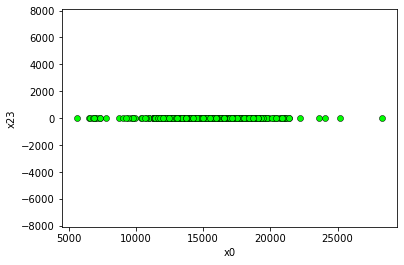

In [45]:
import matplotlib.pyplot as plt
import numpy.linalg as LA 
#plot data
col1 = 'x0'
corr = list(dftrain_x[rho.iloc[:,int(col[1:])].nlargest(2).index])[1]
col2 = dftrain_x[corr]


x = list(dftrain_x[col1])
y = list(col2)

plt.plot(x,y, 'o', c='lime',
            markeredgewidth = 0.5,
            markeredgecolor = 'black')
plt.xlabel(col1)
plt.ylabel(corr)
plt.axis('equal')
plt.show()


In [ ]:
N = 2 #number of most correlated features
const_rows = []
selected_rows = []
for col in dftrain_x.columns:
    model = LR
    #index of nan values
    index = dftrain_x[col].index[dftrain_x[col].apply(np.isnan)]
    
    #constant rows
    if dftrain_x[col].min() == dftrain_x[col].max():
        const_rows.append(col)
        continue
    
    #find rows with n highest correlation
    corr_features = dftrain_x[rho.iloc[:,int(col[1:])].nlargest(N).index]
    
    #cut out nan-rows
    nan_rows = corr_features[corr_features[col].isnull()]
    
    #test and train data
    valid_rows = corr_features.drop(axis=0, index=index, inplace = False)
    y = valid_rows.pop(col)
    X = valid_rows
    
    #impute missing values for prediction
    X = imputer.fit_transform(X)
    
    #scale
    X = scaler.fit_transform(X)
    
    #cross validation
    scores = cross_validate(model, X, y, cv=5,
                    scoring=('r2'),
                    return_train_score=True,
                    n_jobs=4)
    print(col, scores['test_score'].mean(),corr_features.columns)
    
    #add to selection
    if scores['test_score'].mean() >= 0.7:
        selected_rows.append(col)
    
    #fit model
    model.fit(X,y)
    
    #predict nan values
    nan_rows.pop(col)
    prediction_rows = nan_rows
    prediction_rows = imputer.fit_transform(prediction_rows)
    prediction_rows = scaler.fit_transform(prediction_rows)
    predicted_nan_values = model.predict(prediction_rows)
    
    #replace values
    dftrain_x.loc[index,col] = predicted_nan_values
    
    

In [ ]:
#number of correlated features
dftrain_x_selected = dftrain_x[selected_rows]
dftest_x_selected = dftest_x[selected_rows]
print("number of selected features: ", len(selected_rows))

In [ ]:
#heatmap of correlation matrix
import seaborn as sns
plt.subplots(figsize=(20,20)) 
sns.heatmap(dftrain_x.corr())

# Imputation As Before

In [ ]:
dftrain_x2 = pd.read_csv('X_train.csv', index_col='id')
dftrain_y2 = pd.read_csv('y_train.csv', index_col='id')
dftest_x2 = pd.read_csv('X_test.csv', index_col='id')

dftrain_x2[selected_rows] = dftrain_x[selected_rows]
dftest_x2[selected_rows] = dftest_x[selected_rows]

imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(dftrain_x2)
X_test_imp = imputer.transform(dftest_x2)

X_train_imp = pd.DataFrame(X_train_imp, columns=dftrain_x2.columns)
X_test_imp = pd.DataFrame(X_test_imp, columns=dftest_x2.columns)

# Scaling

In [ ]:
# Scaler robust to outliers
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=dftrain_x2.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=dftest_x2.columns)

In [ ]:
X_train_scaled.head()

# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
select = SelectKBest(score_func=f_regression, k=200)
X_train_select = select.fit_transform(X_train_scaled, np.array(dftrain_y2).ravel())
X_test_select = select.transform(X_test_scaled)

X_train_select = pd.DataFrame(X_train_select)
X_test_select = pd.DataFrame(X_test_select)

# Gaussian Processes

In [ ]:
#train model - Gaussian process
kernel = RationalQuadratic() #Matern(nu=0.5) + DotProduct() + WhiteKernel()
GP_model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5, normalize_y=True)

# Cross Validation

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(GP_model, X_train_select, dftrain_y2, cv=3,
                    scoring=('r2'),
                    return_train_score=True,
                    n_jobs=4)


In [ ]:
print(scores['test_score'])

# Kernelized Ridge Rigression

In [ ]:
from sklearn.kernel_ridge import KernelRidge

for mu in range(1,2):
        krr = KernelRidge(alpha=0.001, kernel=RBF())
        scores = cross_validate(krr, X_train_select, dftrain_y2, cv=10,
                    scoring=('r2'),
                    return_train_score=True,
                    n_jobs=4)
        print(mu, scores['test_score'].mean())

In [ ]:
print(scores['test_score'])